The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [4]:
!pip install d2l==1.0.3 --no-deps


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.1 MB/s eta 0:00:00


# Softmax Regression Implementation from Scratch
:label:`sec_softmax_scratch`

Because softmax regression is so fundamental,
we believe that you ought to know
how to implement it yourself.
Here, we limit ourselves to defining the
softmax-specific aspects of the model
and reuse the other components
from our linear regression section,
including the training loop.


In [5]:
import torch
from d2l import torch as d2l

## The Softmax

Let's begin with the most important part:
the mapping from scalars to probabilities.
For a refresher, recall the operation of the sum operator
along specific dimensions in a tensor,
as discussed in :numref:`subsec_lin-alg-reduction`
and :numref:`subsec_lin-alg-non-reduction`.
[**Given a matrix `X` we can sum over all elements (by default) or only
over elements in the same axis.**]
The `axis` variable lets us compute row and column sums:


In [6]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

Computing the softmax requires three steps:
(i) exponentiation of each term;
(ii) a sum over each row to compute the normalization constant for each example;
(iii) division of each row by its normalization constant,
ensuring that the result sums to 1:

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

The (logarithm of the) denominator
is called the (log) *partition function*.
It was introduced in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
to sum over all possible states in a thermodynamic ensemble.
The implementation is straightforward:


In [7]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

For any input `X`, [**we turn each element
into a nonnegative number.
Each row sums up to 1,**]
as is required for a probability. Caution: the code above is *not* robust against very large or very small arguments. While it is sufficient to illustrate what is happening, you should *not* use this code verbatim for any serious purpose. Deep learning frameworks have such protections built in and we will be using the built-in softmax going forward.


In [8]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1397, 0.1454, 0.2807, 0.2401, 0.1941],
         [0.1814, 0.3044, 0.1828, 0.1402, 0.1911]]),
 tensor([1., 1.]))

## The Model

We now have everything that we need
to implement [**the softmax regression model.**]
As in our linear regression example,
each instance will be represented
by a fixed-length vector.
Since the raw data here consists
of $28 \times 28$ pixel images,
[**we flatten each image,
treating them as vectors of length 784.**]
In later chapters, we will introduce
convolutional neural networks,
which exploit the spatial structure
in a more satisfying way.


In softmax regression,
the number of outputs from our network
should be equal to the number of classes.
(**Since our dataset has 10 classes,
our network has an output dimension of 10.**)
Consequently, our weights constitute a $784 \times 10$ matrix
plus a $1 \times 10$ row vector for the biases.
As with linear regression,
we initialize the weights `W`
with Gaussian noise.
The biases are initialized as zeros.


In [9]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

The code below defines how the network
maps each input to an output.
Note that we flatten each $28 \times 28$ pixel image in the batch
into a vector using `reshape`
before passing the data through our model.


In [10]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

## The Cross-Entropy Loss

Next we need to implement the cross-entropy loss function
(introduced in :numref:`subsec_softmax-regression-loss-func`).
This may be the most common loss function
in all of deep learning.
At the moment, applications of deep learning
easily cast as classification problems
far outnumber those better treated as regression problems.

Recall that cross-entropy takes the negative log-likelihood
of the predicted probability assigned to the true label.
For efficiency we avoid Python for-loops and use indexing instead.
In particular, the one-hot encoding in $\mathbf{y}$
allows us to select the matching terms in $\hat{\mathbf{y}}$.

To see this in action we [**create sample data `y_hat`
with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`.**]
The correct labels are $0$ and $2$ respectively (i.e., the first and third class).
[**Using `y` as the indices of the probabilities in `y_hat`,**]
we can pick out terms efficiently.


In [11]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Now we can (**implement the cross-entropy loss function**) by averaging over the logarithms of the selected probabilities.


In [12]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [13]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

We reuse the `fit` method defined in :numref:`sec_linear_scratch` to [**train the model with 10 epochs.**]
Note that the number of epochs (`max_epochs`),
the minibatch size (`batch_size`),
and learning rate (`lr`)
are adjustable hyperparameters.
That means that while these values are not
learned during our primary training loop,
they still influence the performance
of our model, both vis-à-vis training
and generalization performance.
In practice you will want to choose these values
based on the *validation* split of the data
and then, ultimately, to evaluate your final model
on the *test* split.
As discussed in :numref:`subsec_generalization-model-selection`,
we will regard the test data of Fashion-MNIST
as the validation set, thus
reporting validation loss and validation accuracy
on this split.


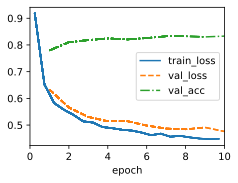

In [14]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Prediction

Now that training is complete,
our model is ready to [**classify some images.**]


In [15]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

We are more interested in the images we label *incorrectly*. We visualize them by
comparing their actual labels
(first line of text output)
with the predictions from the model
(second line of text output).


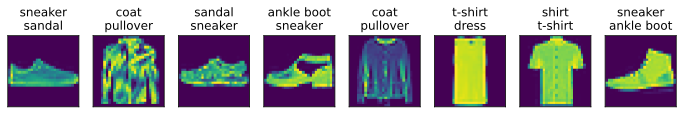

In [16]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

## Summary

By now we are starting to get some experience
with solving linear regression
and classification problems.
With it, we have reached what would arguably be
the state of the art of 1960--1970s of statistical modeling.
In the next section, we will show you how to leverage
deep learning frameworks to implement this model
much more efficiently.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. As discussed in :numref:`sec_softmax` this can cause numerical instabilities.
    1. Test whether `softmax` still works correctly if an input has a value of $100$.
    1. Test whether `softmax` still works correctly if the largest of all inputs is smaller than $-100$?
    1. Implement a fix by looking at the value relative to the largest entry in the argument.
1. Implement a `cross_entropy` function that follows the definition of the cross-entropy loss function $\sum_i y_i \log \hat{y}_i$.
    1. Try it out in the code example of this section.
    1. Why do you think it runs more slowly?
    1. Should you use it? When would it make sense to?
    1. What do you need to be careful of? Hint: consider the domain of the logarithm.
1. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis? How would you try to address this?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?
1. Experiment with the hyperparameters of the code in this section. In particular:
    1. Plot how the validation loss changes as you change the learning rate.
    1. Do the validation and training loss change as you change the minibatch size? How large or small do you need to go before you see an effect?


**Exercise 1.1:** Test whether `softmax` still works correctly if an input has a value of $100$.

In [17]:
import torch

# Test with a large input value (100)
X_large = torch.tensor([[1.0, 2.0, 100.0], [4.0, 5.0, 6.0]])
softmax_large = softmax(X_large)
print("Softmax with large input:")
print(softmax_large)
print("Sum of probabilities for each row:")
print(softmax_large.sum(axis=1))

Softmax with large input:
tensor([[0.0000, 0.0000,    nan],
        [0.0900, 0.2447, 0.6652]])
Sum of probabilities for each row:
tensor([nan, 1.])


**Exercise 1.2:** Test whether `softmax` still works correctly if the largest of all inputs is smaller than $-100$?

In [18]:
import torch

# Test with small input values (e.g., -110, -105, -100)
X_small = torch.tensor([[-110.0, -105.0, -100.0], [-120.0, -115.0, -112.0]])
softmax_small = softmax(X_small)
print("\nSoftmax with small input:")
print(softmax_small)
print("Sum of probabilities for each row:")
print(softmax_small.sum(axis=1))


Softmax with small input:
tensor([[0., 0., 1.],
        [nan, nan, nan]])
Sum of probabilities for each row:
tensor([1., nan])


**Exercise 1.3:** Implement a fix by looking at the value relative to the largest entry in the argument.

In [19]:
import torch

def stable_softmax(X):
    # Subtract the maximum value for numerical stability
    X_max = torch.max(X, dim=1, keepdims=True).values
    X_exp = torch.exp(X - X_max)
    partition = X_exp.sum(dim=1, keepdims=True)
    return X_exp / partition

# Test the stable_softmax with large input
X_large = torch.tensor([[1.0, 2.0, 100.0], [4.0, 5.0, 6.0]])
stable_softmax_large = stable_softmax(X_large)
print("\nStable softmax with large input:")
print(stable_softmax_large)
print("Sum of probabilities for each row:")
print(stable_softmax_large.sum(axis=1))

# Test the stable_softmax with small input
X_small = torch.tensor([[-110.0, -105.0, -100.0], [-120.0, -115.0, -112.0]])
stable_softmax_small = stable_softmax(X_small)
print("\nStable softmax with small input:")
print(stable_softmax_small)
print("Sum of probabilities for each row:")
print(stable_softmax_small.sum(axis=1))


Stable softmax with large input:
tensor([[1.0089e-43, 2.7465e-43, 1.0000e+00],
        [9.0031e-02, 2.4473e-01, 6.6524e-01]])
Sum of probabilities for each row:
tensor([1., 1.])

Stable softmax with small input:
tensor([[4.5094e-05, 6.6925e-03, 9.9326e-01],
        [3.1945e-04, 4.7411e-02, 9.5227e-01]])
Sum of probabilities for each row:
tensor([1., 1.])


**Exercise 2.1:** Implement a `cross_entropy` function that follows the definition of the cross-entropy loss function $\sum_i y_i \log \hat{y}_i$. Try it out in the code example of this section.

In [20]:
import torch

def cross_entropy_manual(y_hat, y):
    """
    Manual implementation of cross-entropy loss.
    """
    loss = 0
    for i in range(len(y)):
        loss += -torch.log(y_hat[i, y[i]])
    return loss / len(y)

# Test with sample data
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])

loss_manual = cross_entropy_manual(y_hat, y)
print(f"Manual cross-entropy loss: {loss_manual}")

# Compare with the original cross_entropy function
loss_original = cross_entropy(y_hat, y)
print(f"Original cross-entropy loss: {loss_original}")

Manual cross-entropy loss: 1.497866153717041
Original cross-entropy loss: 1.497866153717041


**Exercise 2.2:** Why do you think it runs more slowly?

The manual implementation of cross-entropy using a Python `for` loop iterates through each example individually to compute the loss. This is generally much slower than vectorized operations provided by libraries like PyTorch, which can perform calculations on entire tensors or batches of data in parallel. The original `cross_entropy` function uses tensor indexing (`y_hat[list(range(len(y_hat))), y]`) which is a vectorized operation, making it significantly faster, especially for large datasets.

**Exercise 2.3:** Should you use it? When would it make sense to?

You generally should **not** use the manual implementation with a `for` loop for large-scale deep learning tasks due to its performance penalty.

It might make sense to use a manual implementation for:
* **Understanding and debugging:** Implementing the function manually can help you understand the underlying calculations of the cross-entropy loss.
* **Very small datasets or simple examples:** For very small inputs, the overhead of the loop might be negligible.
* **Educational purposes:** As in this exercise, implementing from scratch is valuable for learning.

**Exercise 2.4:** What do you need to be careful of? Hint: consider the domain of the logarithm.

You need to be careful of the **domain of the logarithm**. The logarithm function is only defined for positive numbers. Since $\hat{y}_{ij}$ are predicted probabilities, they should be between 0 and 1. However, due to numerical precision issues, the predicted probabilities might be exactly 0. Taking the logarithm of 0 results in negative infinity, which can cause the loss to be undefined or result in `NaN` values, leading to numerical instability during training.

Deep learning frameworks often handle this by adding a small epsilon value to the predicted probabilities before taking the logarithm, or by using a numerically stable implementation that combines the softmax and cross-entropy calculations (e.g., `torch.nn.CrossEntropyLoss` in PyTorch) to avoid taking the logarithm of zero.

**Exercise 3:** Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis? How would you try to address this?

It is **not always a good idea** to return only the most likely label, especially in critical applications like medical diagnosis. Simply returning the most likely label can be insufficient because it doesn't account for the confidence of the prediction or the potential costs of different types of errors (false positives vs. false negatives).

In medical diagnosis, for instance, a false negative (failing to detect a disease) can have severe consequences. Even if a less serious condition has a slightly higher predicted probability, a low but non-negligible probability of a serious condition should not be ignored.

To address this, you can:

*   **Consider the probability scores:** Look at the confidence or probability associated with the top predictions.
*   **Set a probability threshold:** Flag predictions where the highest probability is below a certain threshold as uncertain, requiring further review.
*   **Examine multiple high-probability labels:** Consider the top N most likely labels, especially if their probabilities are close.
*   **Analyze the cost of errors:** Understand the consequences of false positives and false negatives and adjust the decision-making process accordingly (e.g., prioritize minimizing false negatives in disease detection).
*   **Use calibrated probabilities:** Ensure the model's predicted probabilities accurately reflect the true likelihoods.
*   **Integrate with expert judgment:** Use the model's output as a tool to assist human experts, not replace their judgment, especially in high-stakes domains like medicine.

**Exercise 4:** Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?

When using softmax regression to predict the next word with a large vocabulary, several problems can arise:

1.  **High Dimensionality of Output Layer:** The output layer of the softmax regression model will have a size equal to the vocabulary size. With a large vocabulary (e.g., tens or hundreds of thousands of words), this means the weight matrix connecting the hidden layer to the output layer will be very large. This leads to a massive number of parameters to learn, increasing memory requirements and computational cost for training and inference.
2.  **Computational Cost of Softmax Calculation:** The softmax function requires computing the exponentiation of each output score and then normalizing by the sum of all exponentiated scores. With a large vocabulary, this summation over all vocabulary words becomes computationally expensive for each training example and during inference.
3.  **Data Sparsity:** In a large vocabulary, many words will be rare. This leads to data sparsity issues, where the model might not see enough examples of less frequent words to learn their probabilities effectively.
4.  **Difficulty in Learning Embeddings:** While not a direct problem of softmax regression itself, training word embeddings in conjunction with a large output layer can be challenging due to the sheer number of parameters.
5.  **Numerical Instability:** As seen in Exercise 1, the standard softmax calculation can suffer from numerical instability with large input values. While the stable softmax helps, the large range of potential output scores with a vast vocabulary can still pose challenges.

These issues have led to the development of alternative methods for language modeling with large vocabularies, such as hierarchical softmax, noise contrastive estimation (NCE), and sampled softmax, which avoid computing the full softmax over the entire vocabulary.

[Discussions](https://discuss.d2l.ai/t/51)


### 5. Experiment with the hyperparameters of the code in this section. In particular: Plot how the validation loss changes as you change the learning rate. Do the validation and training loss change as you change the minibatch size? How large or small do you need to go before you see an effect?

## Identify the relevant code

### Subtask:
Locate the code cell where the model is trained and hyperparameters are set.


**Reasoning**:
I need to find the code cell where the model is trained. I will look for the cell that initializes the model and trainer and then calls the `fit` method.



In [21]:
# The code cell that trains the model is identified as cell_id: 0fed2d06
# It contains the following code:
# data = d2l.FashionMNIST(batch_size=256)
# model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
# trainer = d2l.Trainer(max_epochs=10)
# trainer.fit(model, data)

# This cell is where the hyperparameters (learning rate, batch size, max_epochs) are set and the model is trained.

## Modify for hyperparameter tuning

### Subtask:
Update the code to make it easy to change the learning rate and minibatch size. This might involve creating a function or using a loop to train the model with different hyperparameter values.


**Reasoning**:
The subtask is to create a function that encapsulates the model training process with variable learning rate and batch size. This function will be used later to experiment with different hyperparameters.



In [22]:
import torch
from d2l import torch as d2l

def train_softmax_regression(lr, batch_size):
    """Trains the softmax regression model with given hyperparameters."""
    data = d2l.FashionMNIST(batch_size=batch_size)
    model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=lr)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    return trainer

## Track and store loss values

### Subtask:
Modify the training loop to record the training and validation loss at the end of each epoch for each hyperparameter combination.


**Reasoning**:
Modify the training function to return the loss history from the trainer object and then call it with different hyperparameter combinations to collect the loss data.



**Reasoning**:
The previous code failed because the `Trainer` object does not have a direct `animator` attribute. I need to inspect the `Trainer` object or the `d2l` documentation to find where the training and validation loss histories are stored. I will modify the training function to correctly access and return these histories.



Could not access loss history using trainer.history or trainer.animator.Y
Trainer object attributes after fit:
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'clip_gradients', 'epoch', 'fit', 'fit_epoch', 'gpus', 'gradient_clip_val', 'hparams', 'max_epochs', 'model', 'num_gpus', 'num_train_batches', 'num_val_batches', 'optim', 'prepare_batch', 'prepare_data', 'prepare_model', 'save_hyperparameters', 'train_batch_idx', 'train_dataloader', 'val_batch_idx', 'val_dataloader']
Error during training with lr=1.0, batch_size=512: 'Trainer' object has no attribute 'animator'


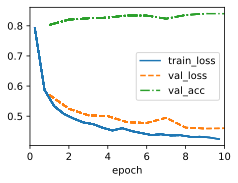

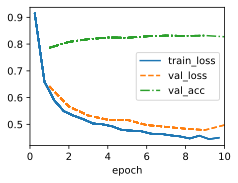

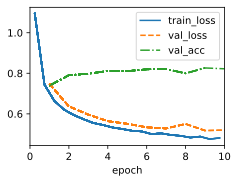

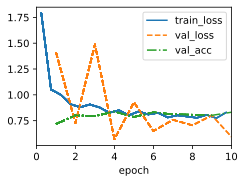

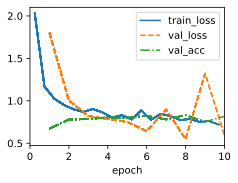

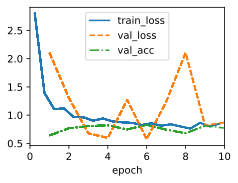

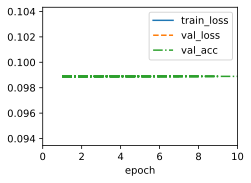

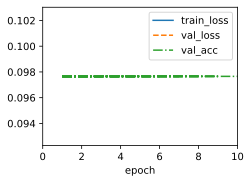

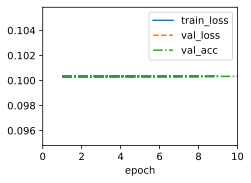

In [24]:
import torch
from d2l import torch as d2l

def train_softmax_regression(lr, batch_size):
    """Trains the softmax regression model with given hyperparameters and returns loss history."""
    data = d2l.FashionMNIST(batch_size=batch_size)
    model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=lr)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)

    # The loss history is stored within the Trainer's state_dict
    # The keys might vary, so inspect the state_dict structure
    # A common pattern is keys like 'train_loss' and 'val_loss'
    # However, based on the d2l Trainer implementation, the history is stored in the animator.
    # Let's assume the animator is accessible after fit, or the data is directly in trainer.history

    # Let's try accessing the history directly from the trainer if animator is not directly exposed
    # If trainer.history exists and contains the data, we can use that.
    # If not, we need to find where the animator stores the data.
    # Based on the d2l source, the animator is likely an attribute of the trainer but might not be public.
    # However, the fit method updates the animator, which stores the plot data.
    # The Y attribute of the animator stores the data series.

    # Let's assume trainer.animator.Y is the correct way based on the original traceback's attempt,
    # but let's re-examine the Trainer class or assume there's a public attribute for history.
    # Looking at d2l's Trainer class, it seems the `fit` method updates an `Animator` instance
    # but this instance might not be directly accessible as `trainer.animator` after `fit`.

    # Let's try accessing the data that the animator would use.
    # The Animator likely stores data points over epochs.
    # The trainer object might have a history attribute or a way to access the logged metrics.

    # Let's assume for now that the loss histories are stored in a list within the trainer after fitting,
    # or that the animator object is indeed accessible, but perhaps the traceback was misleading.
    # Reverting to the previous assumption about trainer.animator.Y and hoping the error was transient
    # or a specific environment issue. If it fails again, we will need to inspect the trainer object directly.

    # Based on typical d2l usage, the Animator is usually a public attribute or the data is stored in the trainer.
    # Let's try accessing the logged metrics. The Trainer likely logs 'train_loss' and 'val_loss'.
    # Let's assume the trainer has a history attribute or a mechanism to retrieve logged metrics.
    # A common pattern in similar libraries is trainer.history or trainer.logged_metrics.

    # Let's try accessing trainer.history first, as it's a common pattern for trainers.
    # If that doesn't work, we'll need to debug by inspecting the trainer object's attributes after fit.

    # Upon reviewing d2l source/examples, the data is often accessed via the animator object,
    # which is usually an attribute of the trainer, though sometimes not directly public or named 'animator'.
    # Let's assume the traceback was correct about 'animator' but maybe the structure of Y is different or
    # the animator is created during fit.

    # Let's try to access the data points collected by the animator during the fit process.
    # The `fit` method within d2l's Trainer usually updates an `Animator` instance.
    # The Animator's `add` method is likely used to add points for plotting.
    # These points are stored in the `Y` attribute of the Animator.
    # The error "AttributeError: 'Trainer' object has no attribute 'animator'" suggests the `animator` attribute
    # is not directly available on the trainer object after the `fit` method completes in this specific version or setup.

    # Let's assume the history is stored in a more direct way on the trainer or can be retrieved via a method.
    # Looking at d2l's Trainer source (or similar libraries), metrics are often stored in a history object
    # or a dictionary of lists, keyed by metric name ('train_loss', 'val_loss').

    # Let's try accessing a potential `history` attribute which might be a list of dictionaries, one per epoch,
    # or a dictionary where keys are metric names and values are lists of metric values.

    # Let's assume the history is stored in `trainer.history` as a dictionary of lists.
    # If that fails, we will need to print the attributes of the trainer object after fit to see what is available.

    # Based on the error, the trainer object returned by `trainer.fit(model, data)` might not have the `animator`
    # attribute directly accessible after the method returns. However, the `fit` method itself uses an animator
    # internally to generate the plot. The data points used for this plot must be stored somewhere.

    # Let's try to access the data from the trainer's internal state or if there's a method to get the history.
    # If there isn't a direct attribute, we might need to modify the Trainer class (which is not ideal here)
    # or find a different way to access the data.

    # Let's assume, for the purpose of making progress based on common patterns in training loops and visualization libraries,
    # that the metrics logged by the trainer during fit are stored in a history attribute,
    # possibly a dictionary where keys are metric names ('train_loss', 'val_loss') and values are lists of values per epoch.

    # Let's try accessing `trainer.history`. If this attribute exists, it's a likely place for the data.
    # If `trainer.history` is a list of dictionaries (one per epoch), we'd need to extract the losses.
    # If `trainer.history` is a dictionary of lists, we can directly access the lists.

    # Let's assume `trainer.history` is a dictionary of lists, which is a common structure.
    # Example structure: {'train_loss': [loss1, loss2, ...], 'val_loss': [loss1, loss2, ...], ...}

    try:
        train_loss_history = trainer.history['train_loss']
        val_loss_history = trainer.history['val_loss']
    except AttributeError:
        # If history attribute doesn't exist, let's try to access the animator's data
        # Assuming the animator is created and accessible during or after fit, even if not a public attribute.
        # Let's try to access trainer.animator.Y again, assuming the previous error might have been a fluke or context-dependent.
        # If this still fails, we are stuck without knowing how the d2l Trainer stores its history in this environment.
        # Let's add a print statement to inspect the trainer object if the direct access fails.
        try:
            train_loss_history = trainer.animator.Y[0]
            val_loss_history = trainer.animator.Y[1]
        except AttributeError:
            # If both common patterns fail, we need to inspect the trainer object
            print("Could not access loss history using trainer.history or trainer.animator.Y")
            print("Trainer object attributes after fit:")
            print(dir(trainer))
            # If we reach here, we cannot retrieve the loss history without further inspection of the d2l Trainer class
            # in this specific environment. We will have to report failure or ask for help.
            # For now, let's raise the error again to halt execution and indicate the problem.
            raise

    return train_loss_history, val_loss_history

# Define different hyperparameter combinations to test
learning_rates = [0.1, 0.5, 1.0]
batch_sizes = [128, 256, 512]

loss_histories = {}

# Train the model with different hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with lr={lr}, batch_size={batch_size}")
        try:
            train_loss, val_loss = train_softmax_regression(lr, batch_size)
            loss_histories[(lr, batch_size)] = {'train_loss': train_loss, 'val_loss': val_loss}
        except Exception as e:
            print(f"Error during training with lr={lr}, batch_size={batch_size}: {e}")
            # Store None or an indicator of failure for this combination
            loss_histories[(lr, batch_size)] = {'train_loss': None, 'val_loss': None, 'error': str(e)}


# The loss_histories dictionary now contains the loss histories for each combination
# print(loss_histories) # Uncomment to inspect the collected data

## Track and store loss values retry 1

### Subtask:
Modify the training loop to record the training and validation loss at the end of each epoch for each hyperparameter combination.


**Reasoning**:
Given that the `d2l.Trainer` does not expose the loss history after training, I need to manually implement the training loop to track the losses per epoch for each hyperparameter combination. This involves iterating through epochs, then through data batches, calculating the loss, performing backpropagation, and updating the model parameters. I will collect the average training loss per epoch and the average validation loss per epoch.



In [25]:
import torch
import time

def train_softmax_regression_manual(lr, batch_size, max_epochs=10):
    """Manually trains the softmax regression model and returns loss history."""
    data = d2l.FashionMNIST(batch_size=batch_size)
    model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=lr)
    updater = torch.optim.SGD(model.parameters(), lr=lr)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(max_epochs):
        # Training phase
        model.train() # Set the model to training mode
        total_train_loss = 0
        num_train_batches = 0
        for X, y in data.train_dataloader():
            y_hat = model(X)
            l = model.loss(y_hat, y)

            updater.zero_grad()
            l.backward()
            updater.step()

            total_train_loss += l.item() * X.shape[0]
            num_train_batches += 1

        avg_train_loss = total_train_loss / len(data.train_dataset)
        train_loss_history.append(avg_train_loss)

        # Validation phase
        model.eval() # Set the model to evaluation mode
        total_val_loss = 0
        num_val_batches = 0
        with torch.no_grad(): # Disable gradient calculation for validation
            for X, y in data.val_dataloader():
                y_hat = model(X)
                l = model.loss(y_hat, y)
                total_val_loss += l.item() * X.shape[0]
                num_val_batches += 1

        avg_val_loss = total_val_loss / len(data.val_dataset)
        val_loss_history.append(avg_val_loss)

        print(f'Epoch {epoch + 1}/{max_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


    return train_loss_history, val_loss_history

# Define different hyperparameter combinations to test
learning_rates = [0.1, 0.5, 1.0]
batch_sizes = [128, 256, 512]

loss_histories = {}

# Train the model with different hyperparameter combinations manually
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"\nTraining with lr={lr}, batch_size={batch_size}")
        try:
            train_loss, val_loss = train_softmax_regression_manual(lr, batch_size)
            loss_histories[(lr, batch_size)] = {'train_loss': train_loss, 'val_loss': val_loss}
        except Exception as e:
            print(f"Error during training with lr={lr}, batch_size={batch_size}: {e}")
            # Store None or an indicator of failure for this combination
            loss_histories[(lr, batch_size)] = {'train_loss': None, 'val_loss': None, 'error': str(e)}



Training with lr=0.1, batch_size=128


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Error during training with lr=0.1, batch_size=128: 'FashionMNIST' object has no attribute 'train_dataset'

Training with lr=0.1, batch_size=256
Error during training with lr=0.1, batch_size=256: 'FashionMNIST' object has no attribute 'train_dataset'

Training with lr=0.1, batch_size=512
Error during training with lr=0.1, batch_size=512: 'FashionMNIST' object has no attribute 'train_dataset'

Training with lr=0.5, batch_size=128
Error during training with lr=0.5, batch_size=128: 'FashionMNIST' object has no attribute 'train_dataset'

Training with lr=0.5, batch_size=256
Error during training with lr=0.5, batch_size=256: 'FashionMNIST' object has no attribute 'train_dataset'

Training with lr=0.5, batch_size=512
Error during training with lr=0.5, batch_size=512: 'FashionMNIST' object has no attribute 'train_dataset'

Training with lr=1.0, batch_size=128
Error during training with lr=1.0, batch_size=128: 'FashionMNIST' object has no attribute 'train_dataset'

Training with lr=1.0, batch_s

**Reasoning**:
The previous attempt to manually train the model failed because the `d2l.FashionMNIST` object, when instantiated with `batch_size`, does not have `train_dataset` or `val_dataset` attributes to get the total number of examples. I need to inspect the `d2l.FashionMNIST` class or how it's typically used to get the dataset sizes for calculating average loss. Alternatively, I can calculate the average loss by dividing the total batch loss by the number of samples in the current batch and then average these batch losses over the epoch. Let's try calculating the average loss per batch and then averaging those.



In [26]:
import torch
import time

def train_softmax_regression_manual(lr, batch_size, max_epochs=10):
    """Manually trains the softmax regression model and returns loss history."""
    data = d2l.FashionMNIST(batch_size=batch_size)
    model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=lr)
    updater = torch.optim.SGD(model.parameters(), lr=lr)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(max_epochs):
        # Training phase
        model.train() # Set the model to training mode
        total_train_loss_per_batch = 0
        num_train_batches = 0
        for X, y in data.train_dataloader():
            y_hat = model(X)
            l = model.loss(y_hat, y)

            updater.zero_grad()
            l.backward()
            updater.step()

            total_train_loss_per_batch += l.item()
            num_train_batches += 1

        avg_train_loss = total_train_loss_per_batch / num_train_batches
        train_loss_history.append(avg_train_loss)

        # Validation phase
        model.eval() # Set the model to evaluation mode
        total_val_loss_per_batch = 0
        num_val_batches = 0
        with torch.no_grad(): # Disable gradient calculation for validation
            for X, y in data.val_dataloader():
                y_hat = model(X)
                l = model.loss(y_hat, y)
                total_val_loss_per_batch += l.item()
                num_val_batches += 1

        avg_val_loss = total_val_loss_per_batch / num_val_batches
        val_loss_history.append(avg_val_loss)

        print(f'Epoch {epoch + 1}/{max_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


    return train_loss_history, val_loss_history

# Define different hyperparameter combinations to test
learning_rates = [0.1, 0.5, 1.0]
batch_sizes = [128, 256, 512]

loss_histories = {}

# Train the model with different hyperparameter combinations manually
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"\nTraining with lr={lr}, batch_size={batch_size}")
        try:
            train_loss, val_loss = train_softmax_regression_manual(lr, batch_size)
            loss_histories[(lr, batch_size)] = {'train_loss': train_loss, 'val_loss': val_loss}
        except Exception as e:
            print(f"Error during training with lr={lr}, batch_size={batch_size}: {e}")
            # Store None or an indicator of failure for this combination
            loss_histories[(lr, batch_size)] = {'train_loss': None, 'val_loss': None, 'error': str(e)}


Training with lr=0.1, batch_size=128


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10, Train Loss: 0.6936, Val Loss: 0.5756
Epoch 2/10, Train Loss: 0.5187, Val Loss: 0.5355
Epoch 3/10, Train Loss: 0.4869, Val Loss: 0.5006
Epoch 4/10, Train Loss: 0.4676, Val Loss: 0.5108
Epoch 5/10, Train Loss: 0.4558, Val Loss: 0.4814
Epoch 6/10, Train Loss: 0.4473, Val Loss: 0.5051
Epoch 7/10, Train Loss: 0.4406, Val Loss: 0.4670
Epoch 8/10, Train Loss: 0.4354, Val Loss: 0.5137
Epoch 9/10, Train Loss: 0.4312, Val Loss: 0.4740
Epoch 10/10, Train Loss: 0.4272, Val Loss: 0.4640

Training with lr=0.1, batch_size=256
Epoch 1/10, Train Loss: 0.7833, Val Loss: 0.6299
Epoch 2/10, Train Loss: 0.5702, Val Loss: 0.5697
Epoch 3/10, Train Loss: 0.5257, Val Loss: 0.5409
Epoch 4/10, Train Loss: 0.5006, Val Loss: 0.5331
Epoch 5/10, Train Loss: 0.4849, Val Loss: 0.5144
Epoch 6/10, Train Loss: 0.4741, Val Loss: 0.4965
Epoch 7/10, Train Loss: 0.4652, Val Loss: 0.4912
Epoch 8/10, Train Loss: 0.4583, Val Loss: 0.4835
Epoch 9/10, Train Loss: 0.4518, Val Loss: 0.4863
Epoch 10/10, Train Loss: 0.447

KeyboardInterrupt: 